In [ ]:
# ! cp drive/My\ Drive/CT.zip .
# ! unzip CT.zip

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import nibabel as nib
from tqdm.notebook import tqdm
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import pandas as pd
import os

ngpu = torch.cuda.device_count()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device, ngpu)

cuda:0 1


In [7]:
class MyConvTranspose2d(nn.Module):
    def __init__(self, conv):
        super(MyConvTranspose2d, self).__init__()
#         self.output_size = output_size
        self.conv = conv
        
    def forward(self, x, output_size):
        x = self.conv(x, output_size=output_size)
        return x
    
class conv_block(nn.Module):
    def __init__(self, num_channels, num_filters):
        super(conv_block, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_filters, (3, 3), padding=1)
        self.conv1_bn = nn.BatchNorm2d(num_filters)
        self.conv2 = nn.Conv2d(num_filters, num_filters, (3, 3), padding=1)
        self.conv2_bn = nn.BatchNorm2d(num_filters) 
    
    def forward(self, inp_tensor):
        encoder = self.conv1(inp_tensor)
        encoder = self.conv1_bn(encoder)
        encoder = torch.relu(encoder)
        encoder = self.conv2(encoder)
        encoder = self.conv2_bn(encoder)
        encoder = torch.relu(encoder)
        return encoder

class encoder_block(nn.Module):
    def __init__(self, num_channels, num_filters):
        super(encoder_block, self).__init__()
        self.conv_block1 = conv_block(num_channels, num_filters)
        self.max_pool1 = nn.MaxPool2d((2, 2), (2, 2))
    
    def forward(self, inp_tensor):
        encoder = self.conv_block1(inp_tensor)
        encoder_pool = self.max_pool1(encoder)
        return (encoder_pool, encoder)

class decoder_block(nn.Module):
    def __init__(self, num_channels, num_filters):
        super(decoder_block, self).__init__()
        conv = nn.ConvTranspose2d(num_channels, num_filters, (2, 2), stride=(2, 2))
        self.conv_tp1 = MyConvTranspose2d(conv)
        self.conv_tp1_bn = nn.BatchNorm2d(2*num_filters)
        self.conv_tp2 = nn.Conv2d(2*num_filters, num_filters, (3, 3), padding=1)
        self.conv_tp2_bn = nn.BatchNorm2d(num_filters)
        self.conv_tp3 = nn.Conv2d(num_filters, num_filters, (3, 3), padding=1)
        self.conv_tp3_bn = nn.BatchNorm2d(num_filters)

    def forward(self, inp_tensor, concat_tensor, output_size):
        decoder = self.conv_tp1(inp_tensor,output_size=output_size)
        decoder = torch.cat((concat_tensor, decoder), 1)
        decoder = self.conv_tp1_bn(decoder)
        decoder = torch.relu(decoder)
        decoder = self.conv_tp2(decoder)
        decoder = self.conv_tp2_bn(decoder)
        decoder = torch.relu(decoder)
        decoder = self.conv_tp3(decoder)
        decoder = self.conv_tp3_bn(decoder)
        decoder = torch.relu(decoder)
        return decoder

In [8]:
class UNet2D(nn.Module):
    def __init__(self, num_classes, num_channels=3):
        super(UNet2D, self).__init__()
        self.encoder_block0 = encoder_block(num_channels, 32)
        self.encoder_block1 = encoder_block(32, 64)
        self.encoder_block2 = encoder_block(64, 128)
        self.encoder_block3 = encoder_block(128, 256)
#         self.encoder_block4 = encoder_block(256, 512)
        self.center = conv_block(256, 512)
#         self.decoder_block4 = decoder_block(1024, 512)
        self.decoder_block3 = decoder_block(512, 256)
        self.decoder_block2 = decoder_block(256, 128)
        self.decoder_block1 = decoder_block(128, 64)
        self.decoder_block0 = decoder_block(64, 32)
        self.conv_final = nn.Conv2d(32, num_classes, (1, 1))
    
    def forward(self, inputs):
        # inputs = x # 256

        encoder0_pool, encoder0 = self.encoder_block0(inputs) # 128
        encoder1_pool, encoder1 = self.encoder_block1(encoder0_pool) # 64
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool) # 32
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool) # 16
#         encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool) # 8

        center = self.center(encoder3_pool) # center (8)

#         decoder4 = self.decoder_block4(center, encoder4) # 16
        
        decoder3 = self.decoder_block3(center, encoder3, output_size=encoder3.shape) # 32
        decoder2 = self.decoder_block2(decoder3, encoder2, output_size=encoder2.shape) # 64
        decoder1 = self.decoder_block1(decoder2, encoder1, output_size=encoder1.shape) # 128
        decoder0 = self.decoder_block0(decoder1, encoder0, output_size=encoder0.shape) # 256

        outputs = torch.sigmoid(self.conv_final(decoder0))
        return outputs

In [9]:
class MO_Net_encoder(nn.Module):
    def __init__(self, num_channels=3):
        super(MO_Net_encoder, self).__init__()
        self.encoder_block0 = encoder_block(num_channels, 32)
        self.encoder_block1 = encoder_block(32, 64)
        self.encoder_block2 = encoder_block(64, 128)
        self.encoder_block3 = encoder_block(128, 256)
        # self.encoder_block4 = encoder_block(256, 512)
        self.center = conv_block(256, 512)
        
    def forward(self, inputs):
        # inputs = x # 256

        encoder0_pool, encoder0 = self.encoder_block0(inputs) # 128
        encoder1_pool, encoder1 = self.encoder_block1(encoder0_pool) # 64
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool) # 32
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool) # 16
        # encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool) # 8
        center = self.center(encoder3_pool) # center (8)

        return encoder0, encoder1, encoder2, encoder3, center


class MO_Net_decoder(nn.Module):
    def __init__(self, num_classes):
        super(MO_Net_decoder, self).__init__()
        # self.decoder_block4 = decoder_block(1024, 512)
        self.decoder_block3 = decoder_block(512, 256)
        self.decoder_block2 = decoder_block(256, 128)
        self.decoder_block1 = decoder_block(128, 64)
        self.decoder_block0 = decoder_block(64, 32)
        self.conv_final = nn.Conv2d(32, num_classes, (1, 1))
            
    def forward(self, encoder0, encoder1, encoder2, encoder3, center):
        # center = x # (8)

        # decoder4 = self.decoder_block4(center, encoder3) # 16
        decoder3 = self.decoder_block3(center, encoder3, output_size=encoder3.shape) # 32
        decoder2 = self.decoder_block2(decoder3, encoder2, output_size=encoder2.shape) # 64
        decoder1 = self.decoder_block1(decoder2, encoder1, output_size=encoder1.shape) # 128
        decoder0 = self.decoder_block0(decoder1, encoder0, output_size=encoder0.shape) # 256

        outputs = torch.sigmoid(self.conv_final(decoder0))
        return outputs

In [10]:
def dice_coeff(y_true, y_pred):
    smooth = 1
    # print(y_true.shape, y_pred.shape)
    assert y_true.shape == y_pred.shape, "Tensor dimensions must match"
    shape = y_true.shape
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    intersection = torch.sum(y_true_flat * y_pred_flat)
    score = (2. * intersection + smooth) / (torch.sum(y_true_flat) + torch.sum(y_pred_flat) + smooth)
    return score

def dice_coeff_multiclass(y_true, y_pred, num_classes):
    dice = []
    output = torch.argmax(y_pred, dim=1)
    y_true = y_true.squeeze(0)
    # print(torch.unique(y_true), torch.unique(output))
    # print(output.shape, y_true.shape)
    for i in range(num_classes):
        segs = y_true.clone().detach()
        segs[y_true==i]=1
        segs[y_true!=i]=0
        # print(torch.unique(segs==y_true))
        outs = output.clone().detach()
        outs[output==i]=1
        outs[output!=i]=0
        # print(torch.unique(outs==output))
        dice.append(dice_coeff(segs, outs).item())
    # print(dice)
    return dice, output, y_true

def dice_loss(true, logits, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model..unsqueeze(0)
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

def bce_dice_loss(y_true, y_pred):
    loss = F.binary_cross_entropy(y_pred, y_true) + dice_loss(y_true, y_pred)
    return loss

def cross_ent_dice_loss(y_true, y_pred):
    # print(y_true.shape, y_pred.shape)
    loss = nn.CrossEntropyLoss
    # y_pred = torch.argmax(y_pred, 1)
    loss = F.cross_entropy(y_pred.float(), y_true) + dice_loss(y_true, y_pred)
    return loss

In [23]:
def get_prior(model, img):
    with torch.no_grad():
        outputs = model(img)
        outputs = torch.argmax(outputs, dim=1)
    return outputs

In [45]:
class Prior(Dataset):
    def __init__(self, root, imgdir, labeldir, prior_list, prior_type, slices=1, train_ratio = 1):
        for x in prior_list:
            if prior_type in x:
                model_fn = '../prior_models/best_model/' + x

        self.slices = slices
        assert self.slices % 2 == 1, "slices must be odd!"

        es = int(self.slices/2) # floor operation

        img_fn = [f for f in sorted(os.listdir(root+imgdir)) if f.endswith('.npy')]
        seg_fn = [f for f in sorted(os.listdir(root+labeldir)) if f.endswith('.npy')]

        if prior_type == 'comp':
            n_classes = 3
        else:
            n_classes = 2
        
        prior_model = UNet2D(n_classes, 1).to(device)
        prior_model.load_state_dict(torch.load(model_fn))


        self.datalist = []
        # prior = torch.from_numpy(np.load('priors/'+str(train_ratio)+'.npy'))
        # prior = prior.unsqueeze(dim=0).type(torch.FloatTensor)
        for i, (img_file, seg_file) in enumerate(zip(img_fn, seg_fn)):

            filename_img = os.path.join(root, imgdir, img_file)
            filename_seg_full = os.path.join(root, labeldir, seg_file)

            assert img_file.replace('.','_').split('_')[1] == seg_file.replace('.','_').split('_')[1], "Image and label files not from the same patient"
            
            seg_img_data = np.load(filename_seg_full)
            img_data = np.load(filename_img)

            assert img_data.shape == seg_img_data.shape, "Image and Labels have different shapes"
            
            for j in range(img_data.shape[2]):
                image2d = torch.from_numpy(img_data[:,:,j]).unsqueeze(dim=0).type(torch.FloatTensor)
                label2d = torch.from_numpy(seg_img_data[:,:,j]).unsqueeze(dim=0).type(torch.LongTensor)
                
                input_img = Variable(image2d).unsqueeze(dim=1).to(device)
                output = get_prior(prior_model, input_img).type(torch.FloatTensor)
                print(image2d.shape, output.shape)
                cat_img = torch.cat((image2d, output), axis=0)

                if (len(torch.unique(label2d))>=2):
                        self.datalist.append([ cat_img, image2d , label2d ])

    def __getitem__(self, index):
        [ cat_img, img, seg] = self.datalist[index]
#         return {"A": img, "B": seg}
        return [cat_img, img, seg]

    def __len__(self):
        return len(self.datalist)

In [14]:
lst = os.listdir('../prior_models/best_model/')
model_name = '../prior_models/best_model/' + lst[0]
prior_model = UNet2D(2, 1).to(device)
prior_model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [83]:
root_dir = '../data/Task04_Hippocampus_processed/train/'
imgdir = 'imagesTr'
labeldir = 'labelsTr'
prior_list = os.listdir('../prior_models/best_model/')
prior_type = 'comp'

validation_split = 0.2
shuffle_dataset = True
random_seed= 42
batch_size = 1
train_ratio = 0.2

dataset = Prior(root = root_dir, imgdir = imgdir, labeldir = labeldir, prior_list = prior_list, prior_type = prior_type, train_ratio = train_ratio)

np.random.seed(0)
torch.manual_seed(0)

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
# print(train_indices, val_indices)

6, 50]) torch.Size([1, 36, 50])
torch.Size([1, 36, 50]) torch.Size([1, 36, 50])
torch.Size([1, 36, 50]) torch.Size([1, 36, 50])
torch.Size([1, 36, 50]) torch.Size([1, 36, 50])
torch.Size([1, 36, 50]) torch.Size([1, 36, 50])
torch.Size([1, 36, 50]) torch.Size([1, 36, 50])
torch.Size([1, 36, 50]) torch.Size([1, 36, 50])
torch.Size([1, 36, 50]) torch.Size([1, 36, 50])
torch.Size([1, 36, 50]) torch.Size([1, 36, 50])
torch.Size([1, 36, 50]) torch.Size([1, 36, 50])
torch.Size([1, 36, 50]) torch.Size([1, 36, 50])
torch.Size([1, 36, 50]) torch.Size([1, 36, 50])
torch.Size([1, 36, 50]) torch.Size([1, 36, 50])
torch.Size([1, 36, 50]) torch.Size([1, 36, 50])
torch.Size([1, 36, 50]) torch.Size([1, 36, 50])
torch.Size([1, 36, 50]) torch.Size([1, 36, 50])
torch.Size([1, 36, 50]) torch.Size([1, 36, 50])
torch.Size([1, 36, 50]) torch.Size([1, 36, 50])
torch.Size([1, 36, 50]) torch.Size([1, 36, 50])
torch.Size([1, 36, 50]) torch.Size([1, 36, 50])
torch.Size([1, 36, 50]) torch.Size([1, 36, 50])
torch.Si

In [94]:
train_ratio = 0.1
np.random.seed(0)
torch.manual_seed(0)

train_sampler = SubsetRandomSampler(train_indices[0:int(train_ratio*len(train_indices))])
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


# dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
n_train = len(train_loader)
n_val = len(validation_loader)
a = iter(train_loader)
batch = a.next()
print(len(batch), n_train, n_val)

3 350 876


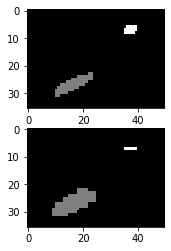

In [85]:
# print(np.unique(dataset[10][2]))
fig = plt.figure()
plt.subplot(2,1,1).imshow(dataset[14][0][1].squeeze().numpy(), cmap='gray')
plt.subplot(2,1,2).imshow(dataset[14][2].squeeze().numpy(), cmap='gray')
plt.show()

In [ ]:
class MSD(Dataset):
    def __init__(self, root, labeldir1, labeldir2, slices=1, train_ratio = 1):
        self.slices = slices
        assert self.slices % 2 == 1, "slices must be odd!"
        es = int(self.slices/2) # floor operation
        img_fn = sorted(os.listdir(root + '/' + 'imagesTr'))
        seg_fn = sorted(os.listdir(root + '/' + labeldir1))
        seg_fn2 = sorted(os.listdir(root + '/' + labeldir2))
        self.datalist = []
        prior = torch.from_numpy(np.load('priors/'+str(train_ratio)+'.npy'))
        prior = prior.unsqueeze(dim=0).type(torch.FloatTensor)
        for i, (img_file, seg_file, seg_file2) in enumerate(zip(img_fn, seg_fn, seg_fn2)):
            assert img_file == seg_file, "Image and label files not from the same patient"
            if (img_file == seg_file):
                seg_img_data = np.load(root + '/' + labeldir1 + '/' + seg_file)
                # print(seg_img_data.shape)
                seg_img_data2 = np.load(root + '/' + labeldir2 + '/' + seg_file2)
                # print(seg_img_data2.shape)
                img_data = np.load(root + '/' + 'imagesTr' + '/' + img_file)
                assert img_data.shape == seg_img_data.shape, "Image and Labels have different shapes"
                for j in range(img_data.shape[2]):
                    w = img_data.shape[0]
                    h = img_data.shape[1]
                    
                    
#                     prior = prior.unsqueeze(dim=0)
#                     print(prior.shape)
                    image2d = torch.from_numpy(img_data[:,:,j]).unsqueeze(dim=0).type(torch.FloatTensor)
#                     print(prior.shape, image2d.shape)
                    cat_img = torch.cat((image2d, prior), axis=0)
                    label2d = torch.from_numpy(seg_img_data[:,:,j]).unsqueeze(dim=0).type(torch.LongTensor)
                    label2d2 = torch.from_numpy(seg_img_data2[:,:,j]).unsqueeze(dim=0).type(torch.LongTensor)
                    # print(image2d.shape, label2d.shape, label2d2.shape)
                    if (len(torch.unique(label2d))>=2):
                        self.datalist.append([ cat_img, image2d , label2d, label2d2 ])

    def __getitem__(self, index):
        [img1, img, seg, seg2] = self.datalist[index]
#         return {"A": img, "B": seg}
        return [img1, img, seg, seg2]

    def __len__(self):
        return len(self.datalist)

In [95]:
# UNet with shape prior

epochs = 30
batch_size = 1
num_classes = 3
losses1 = []

dscoeffs1 = []
val_losses1 = []
val_dscoeffs1 = []
avg_losses1 = []
val_avg_losses1 = []
avg_dscoeffs1 = []
val_avg_dscoeffs1 = []

model0 = UNet2D(3,2).to(device)
optimizer = optim.Adam(model0.parameters(), lr = 0.0001)

In [96]:
params = model0.state_dict()
for item in params:
    if params[item].type() == 'torch.cuda.FloatTensor':
        params[item].requires_grad = True
    if (params[item].requires_grad == True):
        print(item, params[item].requires_grad)

encoder_block0.conv_block1.conv1.weight True
encoder_block0.conv_block1.conv1.bias True
encoder_block0.conv_block1.conv1_bn.weight True
encoder_block0.conv_block1.conv1_bn.bias True
encoder_block0.conv_block1.conv1_bn.running_mean True
encoder_block0.conv_block1.conv1_bn.running_var True
encoder_block0.conv_block1.conv2.weight True
encoder_block0.conv_block1.conv2.bias True
encoder_block0.conv_block1.conv2_bn.weight True
encoder_block0.conv_block1.conv2_bn.bias True
encoder_block0.conv_block1.conv2_bn.running_mean True
encoder_block0.conv_block1.conv2_bn.running_var True
encoder_block1.conv_block1.conv1.weight True
encoder_block1.conv_block1.conv1.bias True
encoder_block1.conv_block1.conv1_bn.weight True
encoder_block1.conv_block1.conv1_bn.bias True
encoder_block1.conv_block1.conv1_bn.running_mean True
encoder_block1.conv_block1.conv1_bn.running_var True
encoder_block1.conv_block1.conv2.weight True
encoder_block1.conv_block1.conv2.bias True
encoder_block1.conv_block1.conv2_bn.weight Tr

---------- EPOCH: 1 ----------
----------- TRAINING -------------


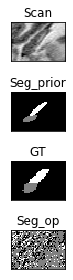

-------------- DONE --------------
---------- VALIDATING ------------


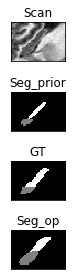

---------- EPOCH: 2 ----------
----------- TRAINING -------------


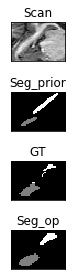

-------------- DONE --------------
---------- VALIDATING ------------


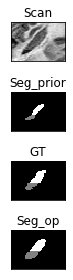

---------- EPOCH: 3 ----------
----------- TRAINING -------------


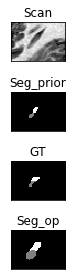

-------------- DONE --------------
---------- VALIDATING ------------


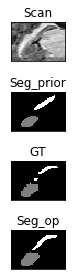

---------- EPOCH: 4 ----------
----------- TRAINING -------------


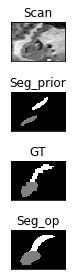

-------------- DONE --------------
---------- VALIDATING ------------


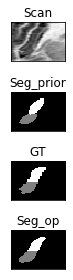

---------- EPOCH: 5 ----------
----------- TRAINING -------------


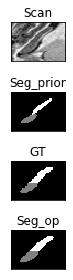

-------------- DONE --------------
---------- VALIDATING ------------


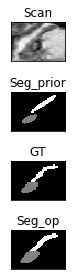

---------- EPOCH: 6 ----------
----------- TRAINING -------------


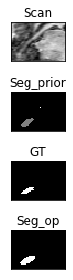

-------------- DONE --------------
---------- VALIDATING ------------


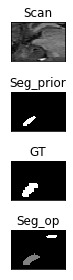

---------- EPOCH: 7 ----------
----------- TRAINING -------------


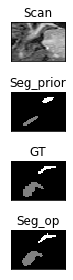

-------------- DONE --------------
---------- VALIDATING ------------


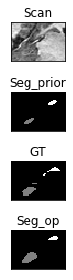

---------- EPOCH: 8 ----------
----------- TRAINING -------------


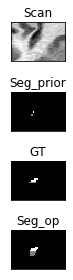

-------------- DONE --------------
---------- VALIDATING ------------


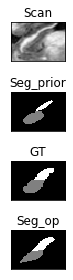

---------- EPOCH: 9 ----------
----------- TRAINING -------------


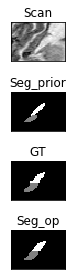

-------------- DONE --------------
---------- VALIDATING ------------


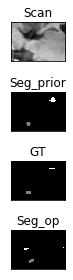

---------- EPOCH: 10 ----------
----------- TRAINING -------------


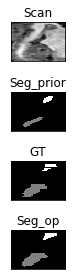

-------------- DONE --------------
---------- VALIDATING ------------


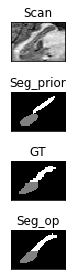

---------- EPOCH: 11 ----------
----------- TRAINING -------------


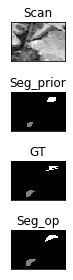

-------------- DONE --------------
---------- VALIDATING ------------


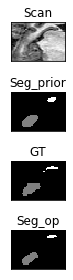

---------- EPOCH: 12 ----------
----------- TRAINING -------------


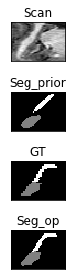

-------------- DONE --------------
---------- VALIDATING ------------


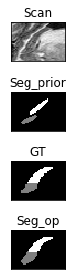

---------- EPOCH: 13 ----------
----------- TRAINING -------------


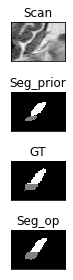

-------------- DONE --------------
---------- VALIDATING ------------


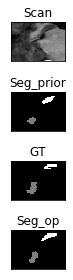

---------- EPOCH: 14 ----------
----------- TRAINING -------------


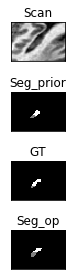

-------------- DONE --------------
---------- VALIDATING ------------


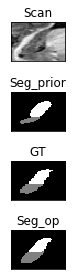

---------- EPOCH: 15 ----------
----------- TRAINING -------------


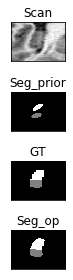

-------------- DONE --------------
---------- VALIDATING ------------


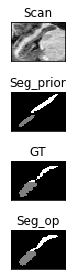

---------- EPOCH: 16 ----------
----------- TRAINING -------------


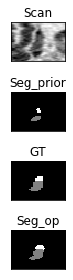

-------------- DONE --------------
---------- VALIDATING ------------


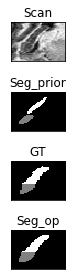

---------- EPOCH: 17 ----------
----------- TRAINING -------------


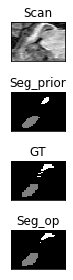

-------------- DONE --------------
---------- VALIDATING ------------


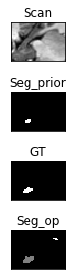

---------- EPOCH: 18 ----------
----------- TRAINING -------------


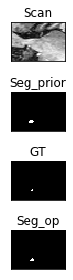

-------------- DONE --------------
---------- VALIDATING ------------


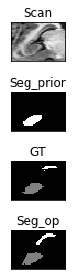

---------- EPOCH: 19 ----------
----------- TRAINING -------------


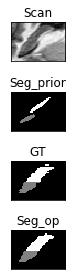

-------------- DONE --------------
---------- VALIDATING ------------


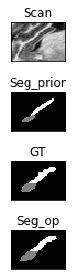

---------- EPOCH: 20 ----------
----------- TRAINING -------------


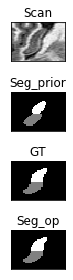

-------------- DONE --------------
---------- VALIDATING ------------


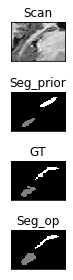

---------- EPOCH: 21 ----------
----------- TRAINING -------------


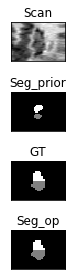

-------------- DONE --------------
---------- VALIDATING ------------


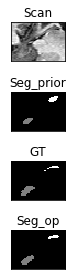

---------- EPOCH: 22 ----------
----------- TRAINING -------------


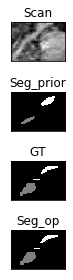

-------------- DONE --------------
---------- VALIDATING ------------


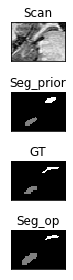

---------- EPOCH: 23 ----------
----------- TRAINING -------------


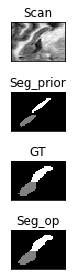

-------------- DONE --------------
---------- VALIDATING ------------


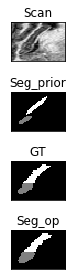

---------- EPOCH: 24 ----------
----------- TRAINING -------------


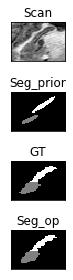

-------------- DONE --------------
---------- VALIDATING ------------


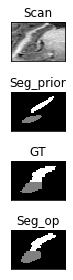

---------- EPOCH: 25 ----------
----------- TRAINING -------------


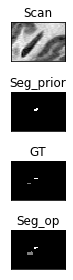

-------------- DONE --------------
---------- VALIDATING ------------


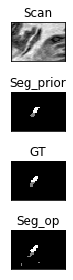

---------- EPOCH: 26 ----------
----------- TRAINING -------------


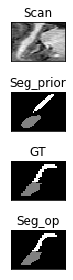

-------------- DONE --------------
---------- VALIDATING ------------


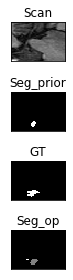

---------- EPOCH: 27 ----------
----------- TRAINING -------------


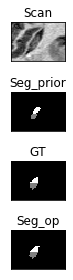

-------------- DONE --------------
---------- VALIDATING ------------


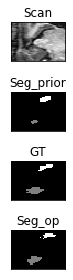

---------- EPOCH: 28 ----------
----------- TRAINING -------------


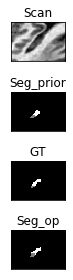

-------------- DONE --------------
---------- VALIDATING ------------


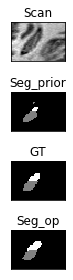

---------- EPOCH: 29 ----------
----------- TRAINING -------------


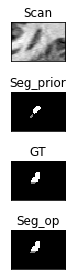

-------------- DONE --------------
---------- VALIDATING ------------


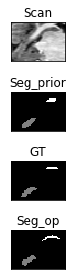

---------- EPOCH: 30 ----------
----------- TRAINING -------------


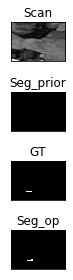

-------------- DONE --------------
---------- VALIDATING ------------


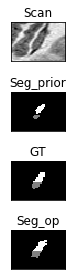

In [97]:
# with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
pbar_outer_outer = tqdm(total=epochs, desc = 'Epoch count')
pbar_outer = tqdm(total=epochs, desc = 'Epoch count')
for epoch in range(1, epochs+1):
    # print('Epoch: ', epoch)
    model0.train()
    avg_loss = 0.0
    avg_dscoeff = 0.0
    print('---------- EPOCH:', epoch, '----------')
    print('----------- TRAINING -------------')
    pbar_inner = tqdm(total = len(train_loader), desc = "train: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    dscoeffs = []
    for i, batch in enumerate(train_loader):
        count+=1
        optimizer.zero_grad()
#         print(len(batch[0]))
        input_img = Variable(batch[0]).to(device)
#         print(input_img[0][0].shape)
        segs = Variable(batch[2]).to(device)
#         print(segs.shape)
        outputs = model0(input_img)
        # print(outputs.shape)
        # print(torch.argmax(outputs, 1).shape)
        
        loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
        loss.backward()
        optimizer.step()
        dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
        dscoeffs.append(dscoeff)
        
        
        if (count%1000==1):
            fig = plt.figure()
            plt.subplot(4,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(4,1,1).set_title('Scan')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(4,1,2).imshow(input_img[0][1].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(4,1,2).set_title('Seg_prior')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(4,1,3).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(4,1,3).set_title('GT')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(4,1,4).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(4,1,4).set_title('Seg_op')
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            plt.show()
        # losses1.append(loss.item())
        # dscoeffs.append(dscoeff)
        avg_loss += loss.item()
        avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
        pbar_inner.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/count,avg_dscoeff/count))
        pbar_inner.update(batch_size)
        pbar_outer.set_description("Epoch count: {}".format(epoch))
    # print(np.array(dscoeffs).shape)
    dscoeffs1.append(np.sum(np.array(dscoeffs), axis = 0)/len(train_loader))
    avg_losses1.append(avg_loss/len(train_loader))
    avg_dscoeffs1.append(avg_dscoeff/len(train_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/len(train_loader),avg_dscoeff/len(train_loader)))
#         pbar.set_postfix(**{'loss (batch)': loss.item(), 'DSC (batch)': dscoeff})
#         pbar.update(i)

    print('-------------- DONE --------------')
    # model0.eval()
    val_avg_loss = 0.0
    val_avg_dscoeff = 0.0
    print('---------- VALIDATING ------------')
    pbar_inner = tqdm(total = len(validation_loader), desc = "Val: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    val_dscoeffs = []
    for i, batch in enumerate(validation_loader):
        with torch.no_grad():
            count+=1
            # optimizer.zero_grad()
    #         print(len(batch[0]))
            input_img = Variable(batch[0]).to(device)
            segs = Variable(batch[2]).to(device)
            outputs = model0(input_img)
            # print(outputs.shape)
            # print(torch.unique(torch.argmax(outputs, 1)))
            
            loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
            # loss.backward()
            # optimizer.step()
            dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
            
            val_dscoeffs.append(dscoeff)
            
            # print(torch.unique(outs))
    #             print("Epoch:", epoch, "| Iter:", i+1, "| loss:", round(loss.item(), 4), "| dsc:", round(dscoeff, 4))
            if (count%1000==1):
                fig = plt.figure()
                plt.subplot(4,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(4,1,1).set_title('Scan')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(4,1,2).imshow(input_img[0][1].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(4,1,2).set_title('Seg_prior')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(4,1,3).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(4,1,3).set_title('GT')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(4,1,4).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(4,1,4).set_title('Seg_op')
                plt.xticks([])
                plt.yticks([])
                plt.tight_layout()
                plt.show()
            # val_losses.append(loss.item())
            # val_dscoeffs.append(dscoeff)
            val_avg_loss += loss.item()
            val_avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
            pbar_inner.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/count,val_avg_dscoeff/count))
            pbar_inner.update(batch_size)
            pbar_outer.set_description("Epoch count: {}".format(epoch))                                                                                     
    val_dscoeffs1.append(np.sum(np.array(val_dscoeffs), axis=0)/len(validation_loader))
    val_avg_dscoeffs1.append(val_avg_dscoeff/len(validation_loader))
    val_avg_losses1.append(val_avg_loss/len(validation_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/len(validation_loader),val_avg_dscoeff/len(validation_loader)))

In [90]:
print(dscoeffs1[-1])
print(val_dscoeffs1[-1])

[0.99778171 0.95242764 0.96274908]
[0.98914113 0.79639514 0.76081831]


In [181]:
# filepath = 'saved_model_UNet_withshape_'+str(train_ratio)+'.pt'
# torch.save(model0.state_dict(), filepath)

In [98]:
# UNet without prior

epochs = 30
batch_size = 1
num_classes = 3
losses2 = []

dscoeffs2 = []
val_losses2 = []
val_dscoeffs2 = []
avg_losses2 = []
val_avg_losses2 = []
avg_dscoeffs2 = []
val_avg_dscoeffs2 = []

model1 = UNet2D(3,1).to(device)
optimizer = optim.Adam(model1.parameters(), lr = 0.0001)

In [99]:
params4 = model1.state_dict()
model1.train(True)
for item in params4:
    # print(params1[item].type())
    if params4[item].type() == 'torch.cuda.FloatTensor':
        params4[item].requires_grad=True
    if (params4[item].requires_grad == True):
        print(item, params4[item].requires_grad)

encoder_block0.conv_block1.conv1.weight True
encoder_block0.conv_block1.conv1.bias True
encoder_block0.conv_block1.conv1_bn.weight True
encoder_block0.conv_block1.conv1_bn.bias True
encoder_block0.conv_block1.conv1_bn.running_mean True
encoder_block0.conv_block1.conv1_bn.running_var True
encoder_block0.conv_block1.conv2.weight True
encoder_block0.conv_block1.conv2.bias True
encoder_block0.conv_block1.conv2_bn.weight True
encoder_block0.conv_block1.conv2_bn.bias True
encoder_block0.conv_block1.conv2_bn.running_mean True
encoder_block0.conv_block1.conv2_bn.running_var True
encoder_block1.conv_block1.conv1.weight True
encoder_block1.conv_block1.conv1.bias True
encoder_block1.conv_block1.conv1_bn.weight True
encoder_block1.conv_block1.conv1_bn.bias True
encoder_block1.conv_block1.conv1_bn.running_mean True
encoder_block1.conv_block1.conv1_bn.running_var True
encoder_block1.conv_block1.conv2.weight True
encoder_block1.conv_block1.conv2.bias True
encoder_block1.conv_block1.conv2_bn.weight Tr

---------- EPOCH: 1 ----------
----------- TRAINING -------------


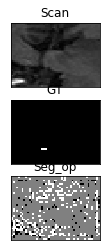

-------------- DONE --------------
---------- VALIDATING ------------


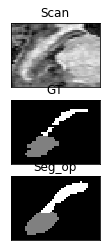

---------- EPOCH: 2 ----------
----------- TRAINING -------------


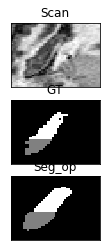

-------------- DONE --------------
---------- VALIDATING ------------


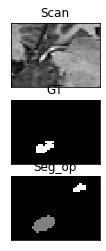

---------- EPOCH: 3 ----------
----------- TRAINING -------------


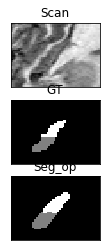

-------------- DONE --------------
---------- VALIDATING ------------


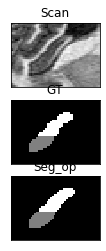

---------- EPOCH: 4 ----------
----------- TRAINING -------------


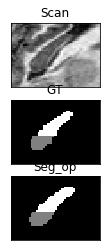

-------------- DONE --------------
---------- VALIDATING ------------


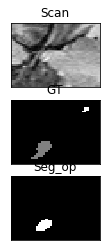

---------- EPOCH: 5 ----------
----------- TRAINING -------------


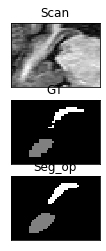

-------------- DONE --------------
---------- VALIDATING ------------


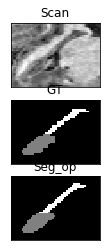

---------- EPOCH: 6 ----------
----------- TRAINING -------------


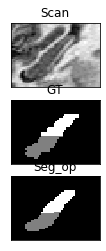

-------------- DONE --------------
---------- VALIDATING ------------


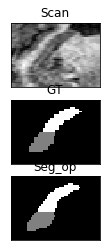

---------- EPOCH: 7 ----------
----------- TRAINING -------------


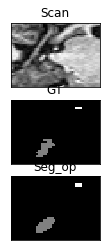

-------------- DONE --------------
---------- VALIDATING ------------


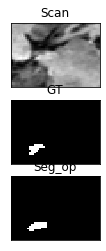

---------- EPOCH: 8 ----------
----------- TRAINING -------------


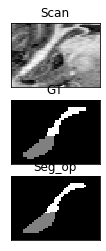

-------------- DONE --------------
---------- VALIDATING ------------


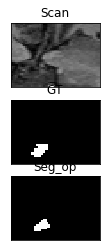

---------- EPOCH: 9 ----------
----------- TRAINING -------------


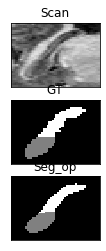

-------------- DONE --------------
---------- VALIDATING ------------


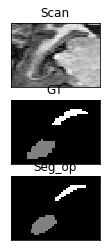

---------- EPOCH: 10 ----------
----------- TRAINING -------------


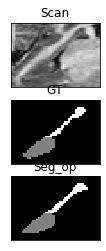

-------------- DONE --------------
---------- VALIDATING ------------


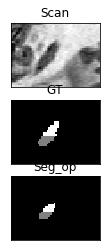

---------- EPOCH: 11 ----------
----------- TRAINING -------------


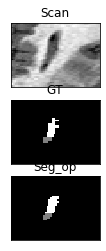

-------------- DONE --------------
---------- VALIDATING ------------


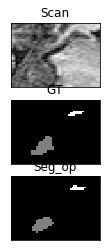

---------- EPOCH: 12 ----------
----------- TRAINING -------------


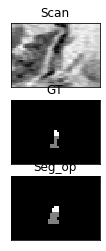

-------------- DONE --------------
---------- VALIDATING ------------


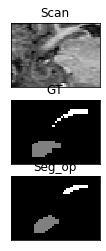

---------- EPOCH: 13 ----------
----------- TRAINING -------------


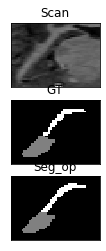

-------------- DONE --------------
---------- VALIDATING ------------


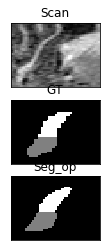

---------- EPOCH: 14 ----------
----------- TRAINING -------------


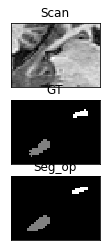

-------------- DONE --------------
---------- VALIDATING ------------


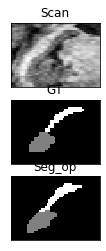

---------- EPOCH: 15 ----------
----------- TRAINING -------------


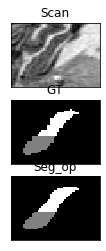

-------------- DONE --------------
---------- VALIDATING ------------


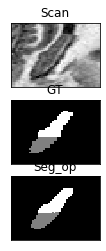

---------- EPOCH: 16 ----------
----------- TRAINING -------------


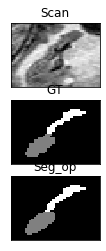

-------------- DONE --------------
---------- VALIDATING ------------


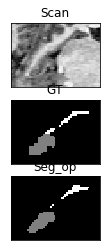

---------- EPOCH: 17 ----------
----------- TRAINING -------------


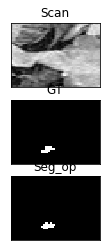

-------------- DONE --------------
---------- VALIDATING ------------


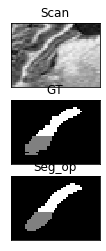

---------- EPOCH: 18 ----------
----------- TRAINING -------------


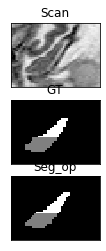

-------------- DONE --------------
---------- VALIDATING ------------


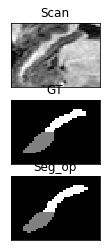

---------- EPOCH: 19 ----------
----------- TRAINING -------------


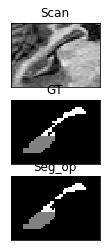

-------------- DONE --------------
---------- VALIDATING ------------


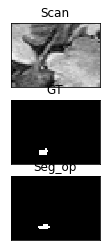

---------- EPOCH: 20 ----------
----------- TRAINING -------------


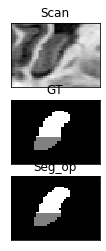

-------------- DONE --------------
---------- VALIDATING ------------


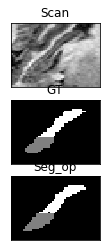

---------- EPOCH: 21 ----------
----------- TRAINING -------------


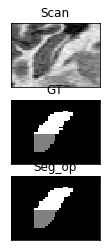

-------------- DONE --------------
---------- VALIDATING ------------


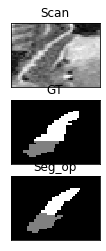

---------- EPOCH: 22 ----------
----------- TRAINING -------------


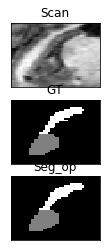

-------------- DONE --------------
---------- VALIDATING ------------


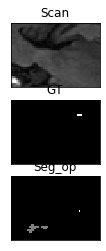

---------- EPOCH: 23 ----------
----------- TRAINING -------------


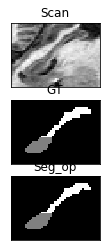

-------------- DONE --------------
---------- VALIDATING ------------


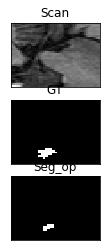

---------- EPOCH: 24 ----------
----------- TRAINING -------------


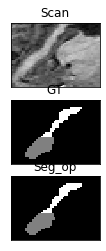

-------------- DONE --------------
---------- VALIDATING ------------


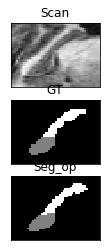

---------- EPOCH: 25 ----------
----------- TRAINING -------------


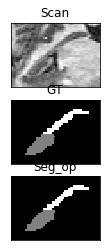

-------------- DONE --------------
---------- VALIDATING ------------


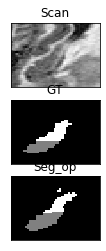

---------- EPOCH: 26 ----------
----------- TRAINING -------------


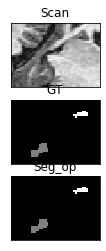

-------------- DONE --------------
---------- VALIDATING ------------


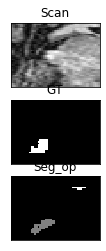

---------- EPOCH: 27 ----------
----------- TRAINING -------------


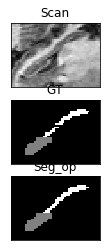

-------------- DONE --------------
---------- VALIDATING ------------


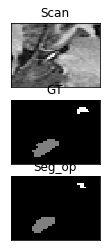

---------- EPOCH: 28 ----------
----------- TRAINING -------------


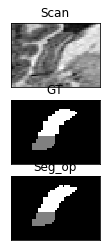

-------------- DONE --------------
---------- VALIDATING ------------


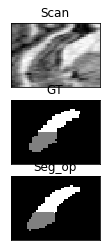

---------- EPOCH: 29 ----------
----------- TRAINING -------------


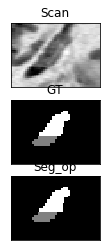

-------------- DONE --------------
---------- VALIDATING ------------


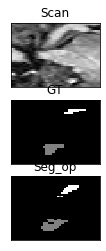

---------- EPOCH: 30 ----------
----------- TRAINING -------------


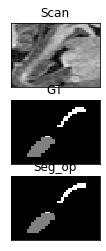

-------------- DONE --------------
---------- VALIDATING ------------


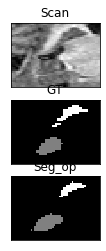

In [100]:
# with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
pbar_outer_outer = tqdm(total=epochs, desc = 'Epoch count')
pbar_outer = tqdm(total=epochs, desc = 'Epoch count')
for epoch in range(1, epochs+1):
    # print('Epoch: ', epoch)
    model1.train()
    avg_loss = 0.0
    avg_dscoeff = 0.0
    print('---------- EPOCH:', epoch, '----------')
    print('----------- TRAINING -------------')
    pbar_inner = tqdm(total = len(train_loader), desc = "train: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    dscoeffs = []
    for i, batch in enumerate(train_loader):
        count+=1
        optimizer.zero_grad()
#         print(len(batch[0]))
        input_img = Variable(batch[1]).to(device)
#         print(input_img[0][0].shape)
        segs = Variable(batch[2]).to(device)
#         print(segs.shape)
        outputs = model1(input_img)
        # print(outputs.shape)
        # print(torch.argmax(outputs, 1).shape)
        
        loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
        loss.backward()
        optimizer.step()
        dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
        dscoeffs.append(dscoeff)
        
        
        if (count%1000==1):
            fig = plt.figure()
            plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,1).set_title('Scan')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,2).set_title('GT')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,3).set_title('Seg_op')
            plt.xticks([])
            plt.yticks([])
            plt.show()
        # losses1.append(loss.item())
        # dscoeffs.append(dscoeff)
        avg_loss += loss.item()
        avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
        pbar_inner.set_description("train: Avg lnum_classesoss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/count,avg_dscoeff/count))
        pbar_inner.update(batch_size)
        pbar_outer.set_description("Epoch count: {}".format(epoch))
    # print(np.array(dscoeffs).shape)
    dscoeffs2.append(np.sum(np.array(dscoeffs), axis = 0)/len(train_loader))
    avg_losses2.append(avg_loss/len(train_loader))
    avg_dscoeffs2.append(avg_dscoeff/len(train_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/len(train_loader),avg_dscoeff/len(train_loader)))
#         pbar.set_postfix(**{'loss (batch)': loss.item(), 'DSC (batch)': dscoeff})
#         pbar.update(i)

    print('-------------- DONE --------------')
    # model0.eval()
    val_avg_loss = 0.0
    val_avg_dscoeff = 0.0
    print('---------- VALIDATING ------------')
    pbar_inner = tqdm(total = len(validation_loader), desc = "Val: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    val_dscoeffs = []
    for i, batch in enumerate(validation_loader):
        with torch.no_grad():
            count+=1
            # optimizer.zero_grad()
    #         print(len(batch[0]))
            input_img = Variable(batch[1]).to(device)
            segs = Variable(batch[2]).to(device)
            outputs = model1(input_img)
            # print(outputs.shape)
            # print(torch.unique(torch.argmax(outputs, 1)))
            
            loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
            # loss.backward()
            # optimizer.step()
            dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
            
            val_dscoeffs.append(dscoeff)
            
            # print(torch.unique(outs))
    #             print("Epoch:", epoch, "| Iter:", i+1, "| loss:", round(loss.item(), 4), "| dsc:", round(dscoeff, 4))
            if (count%1000==1):
                fig = plt.figure()
                plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,1).set_title('Scan')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,2).set_title('GT')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,3).set_title('Seg_op')
                plt.xticks([])
                plt.yticks([])
                plt.show()
            # val_losses.append(loss.item())
            # val_dscoeffs.append(dscoeff)
            val_avg_loss += loss.item()
            val_avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
            pbar_inner.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/count,val_avg_dscoeff/count))
            pbar_inner.update(batch_size)
            pbar_outer.set_description("Epoch count: {}".format(epoch))
    val_dscoeffs2.append(np.sum(np.array(val_dscoeffs), axis=0)/len(validation_loader))
    val_avg_dscoeffs2.append(val_avg_dscoeff/len(validation_loader))
    val_avg_losses2.append(val_avg_loss/len(validation_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/len(validation_loader),val_avg_dscoeff/len(validation_loader)))

In [78]:
print(dscoeffs2[-2])
print(val_dscoeffs2[-2])

[0.99690225 0.94784293 0.94313646]
[0.99140695 0.8441891  0.81205478]


In [186]:
filepath = 'saved_model_UNet_withoutshape_'+str(train_ratio)+'.pt'
torch.save(model1.state_dict(), filepath)

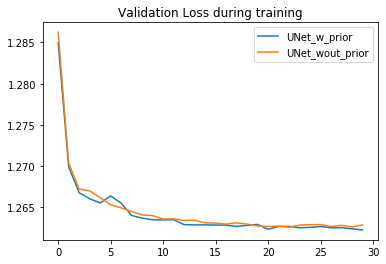

In [79]:
fig=plt.figure()
plt.plot(val_avg_losses1, label = 'UNet_w_prior')
plt.plot(val_avg_losses2, label = 'UNet_wout_prior')
plt.legend()
plt.title('Validation Loss during training')
plt.show()
# fig.savefig('Plots/Shape_Prior_valloss'+str(train_ratio)+'.jpg')

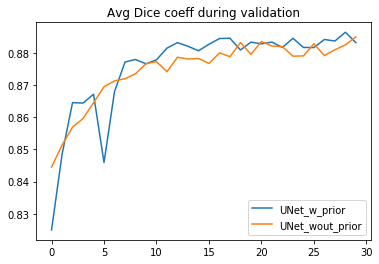

In [80]:
fig=plt.figure()
plt.plot(val_avg_dscoeffs1, label = 'UNet_w_prior')
plt.plot(val_avg_dscoeffs2, label = 'UNet_wout_prior')
plt.title('Avg Dice coeff during validation')
plt.legend()
plt.show()
# fig.savefig('Plots/Shape_Prior_valdice'+str(train_ratio)+'.jpg')

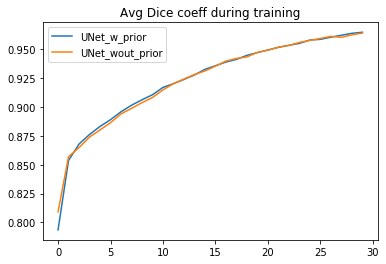

In [81]:
fig=plt.figure()
plt.plot(avg_dscoeffs1, label = 'UNet_w_prior')
plt.plot(avg_dscoeffs2, label = 'UNet_wout_prior')
plt.title('Avg Dice coeff during training')
plt.legend()
plt.show()
# fig.savefig('Plots/Shape_Prior_traindice'+str(train_ratio)+'.jpg')

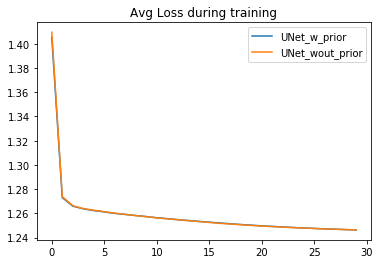

In [82]:
fig=plt.figure()
plt.plot(avg_losses1, label = 'UNet_w_prior')
plt.plot(avg_losses2, label = 'UNet_wout_prior')
plt.title('Avg Loss during training')
plt.legend()
plt.show()
# fig.savefig('Plots/Shape_Prior_trainloss'+str(train_ratio)+'.jpg')